### Import necessary libraries

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import numpy as np
import os
from PIL import Image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.layers import Input, Concatenate
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

### Import data

In [2]:
# Import data

# Data
fname='elpv-dataset-1.0/labels.csv'


# Load the dataset
data = np.genfromtxt(fname, dtype=['|S19', '<f8', '|S4'], names=['path', 'probability', 'type'])
image_fnames = np.char.decode(data['path'])
probs = data['probability']
types = np.char.decode(data['type'])

# Define a function to preprocess the images
def load_and_preprocess_image(fname):
    with Image.open(fname) as image:
        # Preprocess image for ResNet50
        image = image.convert('RGB')
        image = image.resize((224, 224))
        image = np.array(image)
        image = preprocess_input(image)  # Use the imported function here
        return image

# Load and preprocess images
dir = os.path.dirname(fname)
images = np.array([load_and_preprocess_image(os.path.join(dir, fn))
                   for fn in image_fnames])

### One hot encode the type variable

In [14]:

# Convert probabilities to categorical labels
labels = to_categorical(np.round(probs * 3), num_classes=4)


# One hot encode the types variable

label_encoder = LabelEncoder()
integer_encoded_types = label_encoder.fit_transform(types)

# One-hot encode the integer labels
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded_types = integer_encoded_types.reshape(len(integer_encoded_types), 1)
onehot_encoded_types = onehot_encoder.fit_transform(integer_encoded_types)

# Split the dataset into training and testing
X_train, X_test, y_train, y_test, type_train, type_test = train_test_split(
    images, labels, onehot_encoded_types, test_size=0.25, random_state=42)




C:\ProgramData\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### Undertake data augmentation (to training dataset only)

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

X_train, X_test, y_train, y_test, type_train, type_test = train_test_split(
    images, labels, onehot_encoded_types, test_size=0.25, random_state=42)

# Assuming X_train, y_train, and type_train are your original datasets
augmented_images = []
augmented_labels = []
augmented_types = []  # To store the type data for each image
augmentation_flags = []  # 1 for augmented, 0 for original

# Define your ImageDataGenerator with desired augmentations
train_datagen = ImageDataGenerator(
    # rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    horizontal_flip=True
    # Add any other augmentations you need
)

# Decide how many augmented images you want per original image
augmentations_per_image = 1

for i in range(len(X_train)):
    image = X_train[i].reshape((1,) + X_train[i].shape)
    label = y_train[i]
    type_data = type_train[i]

    # Add the original image and its data to the lists
    augmented_images.append(X_train[i])
    augmented_labels.append(label)
    augmented_types.append(type_data)
    augmentation_flags.append(0)  # Original image, not augmented

    # Generate augmented images
    count = 0
    for x_batch, y_batch in train_datagen.flow(image, np.array([label]), batch_size=1, seed=42):
        augmented_images.append(x_batch[0])
        augmented_labels.append(y_batch[0])
        augmented_types.append(type_data)  # The type data remains the same for augmented images
        augmentation_flags.append(1)  # Augmented image
        count += 1
        if count >= augmentations_per_image:
            break

# Convert lists to numpy arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)
augmented_types = np.array(augmented_types)
augmentation_flags = np.array(augmentation_flags)

# Now, augmented_images, augmented_labels, augmented_types, and augmentation_flags are your datasets

# Define two inputs for the model: one for the image and one for the module type
image_input = Input(shape=(224, 224, 3))
type_input = Input(shape=(onehot_encoded_types.shape[1],))  # The shape of the type input

In [25]:
augmented_images.shape

(3936, 224, 224, 3)

In [28]:
X_test.shape

(656, 224, 224, 3)

### Model definition and fit

In [31]:
from tensorflow.keras.layers import Input

# Define inputs for the model
image_input = Input(shape=(224, 224, 3))
type_input = Input(shape=(augmented_types.shape[1],))

# Load the ResNet50 model pre-trained on ImageNet data
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=image_input)


# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

    
# Model architecture
x1 = GlobalAveragePooling2D()(base_model.output)
combined = Concatenate()([x1, type_input])
x = Dense(1024, activation='relu')(combined)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)
    
# Create the final model with two inputs
model = Model(inputs=[image_input, type_input], outputs=predictions)


# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping and Model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)





history = model.fit(
    [augmented_images, augmented_types], augmented_labels,
    # steps_per_epoch=len(X_train) // batch_size,
    batch_size = 32, 
    epochs=10,
    validation_data=([X_test, type_test], y_test),
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/10
123/123 [==============================] - ETA: 0s - loss: 0.9606 - accuracy: 0.6542

C:\Users\abhij\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


123/123 [==============================] - 209s 2s/step - loss: 0.9606 - accuracy: 0.6542 - val_loss: 0.7421 - val_accuracy: 0.7271
Epoch 2/10
123/123 [==============================] - 202s 2s/step - loss: 0.7589 - accuracy: 0.7254 - val_loss: 0.7074 - val_accuracy: 0.7393
Epoch 3/10
123/123 [==============================] - 196s 2s/step - loss: 0.6884 - accuracy: 0.7439 - val_loss: 0.6737 - val_accuracy: 0.7439
Epoch 4/10
123/123 [==============================] - 196s 2s/step - loss: 0.6504 - accuracy: 0.7574 - val_loss: 0.6733 - val_accuracy: 0.7424
Epoch 5/10
123/123 [==============================] - 199s 2s/step - loss: 0.6118 - accuracy: 0.7698 - val_loss: 0.6667 - val_accuracy: 0.7470
Epoch 6/10
123/123 [==============================] - 196s 2s/step - loss: 0.5865 - accuracy: 0.7790 - val_loss: 0.6677 - val_accuracy: 0.7530
Epoch 7/10
123/123 [==============================] - 197s 2s/step - loss: 0.5577 - accuracy: 0.7973 - val_loss: 0.6758 - val_accuracy: 0.7668
Epoch 8/10

21/21 [==============================] - 29s 1s/step
Confusion Matrix for Type mono:
[[137   6   1   3]
 [ 11   8   4   3]
 [ 10   1   4   3]
 [ 11   2   7  62]]

Classification Report for Type mono:
                     precision    recall  f1-score   support

   Fully Functional       0.81      0.93      0.87       147
 Possibly Defective       0.47      0.31      0.37        26
   Likely Defective       0.25      0.22      0.24        18
Certainly Defective       0.87      0.76      0.81        82

           accuracy                           0.77       273
          macro avg       0.60      0.55      0.57       273
       weighted avg       0.76      0.77      0.76       273



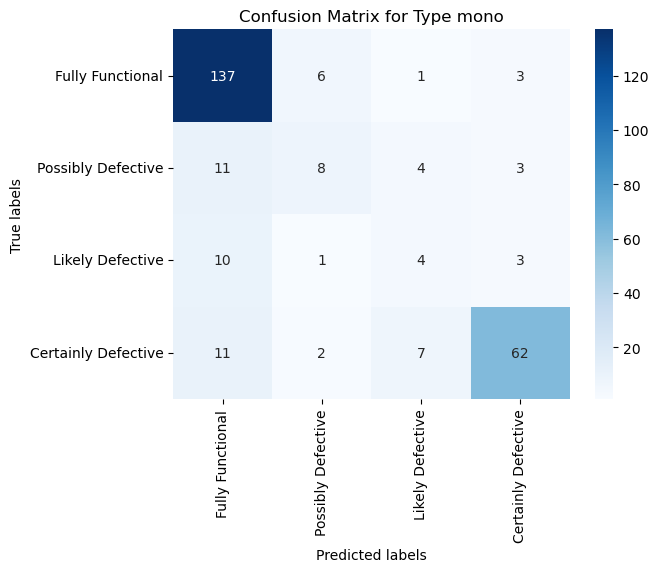

Confusion Matrix for Type poly:
[[195  17   0  13]
 [ 16  27   0   4]
 [  7   2   0   4]
 [ 12   6   1  79]]

Classification Report for Type poly:
                     precision    recall  f1-score   support

   Fully Functional       0.85      0.87      0.86       225
 Possibly Defective       0.52      0.57      0.55        47
   Likely Defective       0.00      0.00      0.00        13
Certainly Defective       0.79      0.81      0.80        98

           accuracy                           0.79       383
          macro avg       0.54      0.56      0.55       383
       weighted avg       0.76      0.79      0.77       383



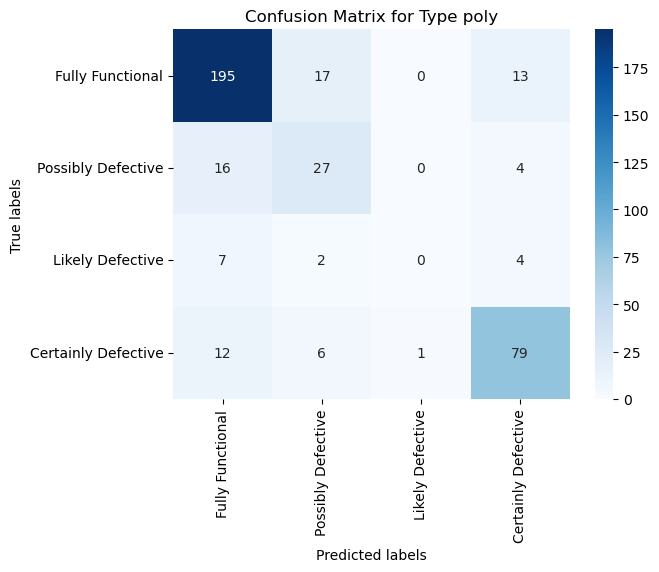

Confusion Matrix for Entire Dataset:
[[332  23   1  16]
 [ 27  35   4   7]
 [ 17   3   4   7]
 [ 23   8   8 141]]

Classification Report for Entire Dataset:
                     precision    recall  f1-score   support

   Fully Functional       0.83      0.89      0.86       372
 Possibly Defective       0.51      0.48      0.49        73
   Likely Defective       0.24      0.13      0.17        31
Certainly Defective       0.82      0.78      0.80       180

           accuracy                           0.78       656
          macro avg       0.60      0.57      0.58       656
       weighted avg       0.77      0.78      0.77       656



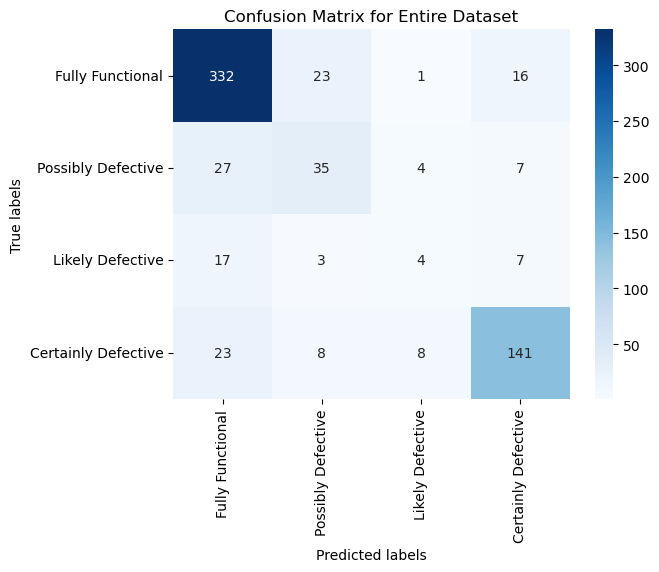

In [33]:

# Predict the test set results
y_pred = model.predict([X_test, type_test])
y_pred_classes = np.argmax(y_pred, axis=1)


# Accuracy stats
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Convert y_test from one-hot encoding to class indices
y_test_classes = np.argmax(y_test, axis=1)

# Convert type_test from one-hot encoding to original labels
type_test_labels = label_encoder.inverse_transform(np.argmax(type_test, axis=1))

# Unique types
unique_types = np.unique(type_test_labels)

# Evaluate for each type
for t in unique_types:
    # Indices for current type
    indices = np.where(type_test_labels == t)

    # Subset y_test_classes and y_pred_classes
    y_test_subset = y_test_classes[indices]
    y_pred_subset = y_pred_classes[indices]

    # Confusion Matrix for current type
    cm = confusion_matrix(y_test_subset, y_pred_subset)
    print(f"Confusion Matrix for Type {t}:")
    print(cm)

    # Classification Report for current type
    report = classification_report(y_test_subset, y_pred_subset, target_names=['Fully Functional', 'Possibly Defective', 'Likely Defective', 'Certainly Defective'], zero_division = 0)
    print(f"\nClassification Report for Type {t}:")
    print(report)

    # Visualization of Confusion Matrix for current type
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Fully Functional', 'Possibly Defective', 'Likely Defective', 'Certainly Defective'], yticklabels=['Fully Functional', 'Possibly Defective', 'Likely Defective', 'Certainly Defective'])
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix for Type {t}')
    plt.show()

    
cm_total = confusion_matrix(y_test_classes, y_pred_classes)
report_total = classification_report(y_test_classes, y_pred_classes, target_names=['Fully Functional', 'Possibly Defective', 'Likely Defective', 'Certainly Defective'], zero_division=0)

print("Confusion Matrix for Entire Dataset:")
print(cm_total)
print("\nClassification Report for Entire Dataset:")
print(report_total)

sns.heatmap(cm_total, annot=True, fmt='g', cmap='Blues', xticklabels=['Fully Functional', 'Possibly Defective', 'Likely Defective', 'Certainly Defective'], yticklabels=['Fully Functional', 'Possibly Defective', 'Likely Defective', 'Certainly Defective'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Entire Dataset')
plt.show()